### Car Brand Classification using Deep Learning

In [ ]:
!unzip "Datasets.zip"

### Import Libraries


In [43]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Convolution2D,MaxPooling2D,Flatten
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import tensorflow.keras as K
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

### CNN Model without using Transfer Learning 

In [3]:
### Initializing CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (64, 64, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(256, activation = 'relu'))
classifier.add(Dense(3, activation = 'softmax'))

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 21, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 1, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 256)               8448      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

In [4]:
# Compiling the CNN
classifier.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])
### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('car_brand_without_transfer_learning.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

### Data Augmentation and Training

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('Datasets/Train',
                                                 target_size = (64, 64),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Datasets/Test',
                                            target_size = (64, 64),
                                            batch_size = 16,
                                            class_mode = 'categorical')

print('Length of Training Set : ' , len(training_set))
print('Length of Test Set : ' , len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print('Train Steps per epoch : ', train_steps_per_epoch)
print('Validation Steps per epoch : ' , val_steps_per_epoch)

# fit the model
history = classifier.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=10,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[lr_reduce, early_stop, checkpoint])

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.
Length of Training Set :  4
Length of Test Set :  4
Train Steps per epoch :  0
Validation Steps per epoch :  0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
4/4 [==============================] - 3s 166ms/step - loss: 1.0978 - accuracy: 0.3271 - val_loss: 1.1117 - val_accuracy: 0.1724

Epoch 00001: val_accuracy improved from -inf to 0.17241, saving model to car_brand_without_transfer_learning.h5
Epoch 2/10
4/4 [==============================] - 0s 67ms/step - loss: 1.0970 - accuracy: 0.3729 - val_loss: 1.1125 - val_accuracy: 0.1552

Epoch 00002: val_accuracy did not improve from 0.17241
Epoch 3/10
4/4 [==============================] - 0s 63ms/step - loss: 1.0951 - accuracy: 0.4125 - val_loss: 1.1138 - val_accuracy: 0.1724

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00003: val_accuracy did not improve from 0.17241
Epoch 4/10
4/4 [==============================] - 0s 67ms/step - loss: 1.0960 - accuracy: 0.3729 - val_loss: 1.1141 - val_accuracy: 0.1897

Epoch 00004: val_accuracy improved from 0.17241 to 0.18966, saving model to car_brand_without_transfer_learning.h5
Epoch 5/10
4/4 [=====

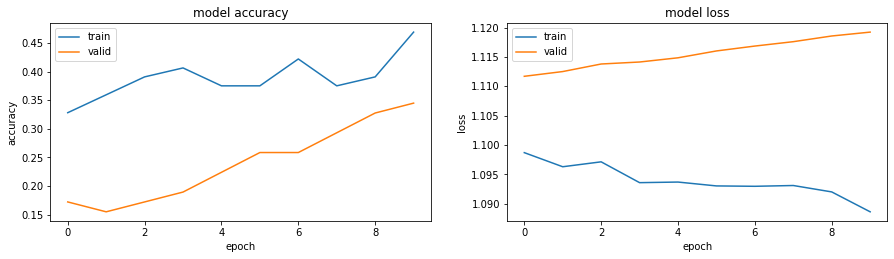

In [6]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### Car Brand Classification using Transfer Learning - VGG19

In [15]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

# useful for getting number of classes
folders = glob('Datasets/Train/*')
initializer = K.initializers.he_normal()

model = K.applications.VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='relu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [16]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('car_brand_vgg19.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')

In [17]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('Datasets/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Datasets/Test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

print('Length of Training Set : ' , len(training_set))
print('Length of Test Set : ' , len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print('Train Steps per epoch : ', train_steps_per_epoch)
print('Validation Steps per epoch : ' , val_steps_per_epoch)

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[lr_reduce, early_stop, checkpoint])

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.
Length of Training Set :  4
Length of Test Set :  4
Train Steps per epoch :  0
Validation Steps per epoch :  0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
4/4 [==============================] - 2s 384ms/step - loss: 6.7192 - accuracy: 0.3396 - val_loss: 5.8267 - val_accuracy: 0.6207

Epoch 00001: val_accuracy improved from -inf to 0.62069, saving model to car_brand_vgg19.h5
Epoch 2/50
4/4 [==============================] - 1s 298ms/step - loss: 6.0111 - accuracy: 0.5292 - val_loss: 5.8383 - val_accuracy: 0.5172

Epoch 00002: val_accuracy did not improve from 0.62069
Epoch 3/50
4/4 [==============================] - 1s 304ms/step - loss: 5.7252 - accuracy: 0.4833 - val_loss: 5.4679 - val_accuracy: 0.5000

Epoch 00003: ReduceLROnPlateau reducing learning rate to 5.999999848427251e-05.

Epoch 00003: val_accuracy did not improve from 0.62069
Epoch 4/50
4/4 [==============================] - 1s 298ms/step - loss: 5.3484 - accuracy: 0.6458 - val_loss: 5.2352 - val_accuracy: 0.6897

Epoch 00004: val_accuracy improved from 0.62069 to 0.68966, saving model to car_brand_vgg19.h5
Epoch 5/50
4/4 [==============================] - 1s 315ms

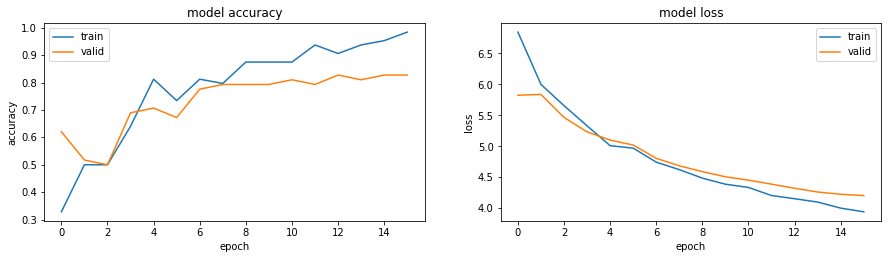

In [18]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### RESNET-152-V2

In [19]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

# useful for getting number of classes
folders = glob('Datasets/Train/*')
folders
initializer = K.initializers.he_normal()

model = K.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False

output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='relu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

In [20]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('car_brand_resnet152v2.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('Datasets/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Datasets/Test',
                                            target_size = (224, 224),
                                            batch_size = 16,
                                            class_mode = 'categorical')

print('Length of Training Set : ' , len(training_set))
print('Length of Test Set : ' , len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print('Train Steps per epoch : ', train_steps_per_epoch)
print('Validation Steps per epoch : ' , val_steps_per_epoch)

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[lr_reduce, early_stop, checkpoint])

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.
Length of Training Set :  4
Length of Test Set :  4
Train Steps per epoch :  0
Validation Steps per epoch :  0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
4/4 [==============================] - 11s 1s/step - loss: 8.7604 - accuracy: 0.3896 - val_loss: 5.8151 - val_accuracy: 0.7241

Epoch 00001: val_accuracy improved from -inf to 0.72414, saving model to car_brand_resnet152v2.h5
Epoch 2/50
4/4 [==============================] - 1s 372ms/step - loss: 6.4574 - accuracy: 0.6354 - val_loss: 5.4180 - val_accuracy: 0.7586

Epoch 00002: val_accuracy improved from 0.72414 to 0.75862, saving model to car_brand_resnet152v2.h5
Epoch 3/50
4/4 [==============================] - 1s 370ms/step - loss: 4.5393 - accuracy: 0.8833 - val_loss: 4.7541 - val_accuracy: 0.7931

Epoch 00003: val_accuracy improved from 0.75862 to 0.79310, saving model to car_brand_resnet152v2.h5
Epoch 4/50
4/4 [==============================] - 1s 371ms/step - loss: 4.4612 - accuracy: 0.8792 - val_loss: 4.7564 - val_accuracy: 0.7586

Epoch 00004: val_accuracy did not improve from 0.79310
Epoch 5/50
4/4 [==============================] - 1s 383ms/step - loss: 3.8638 - ac

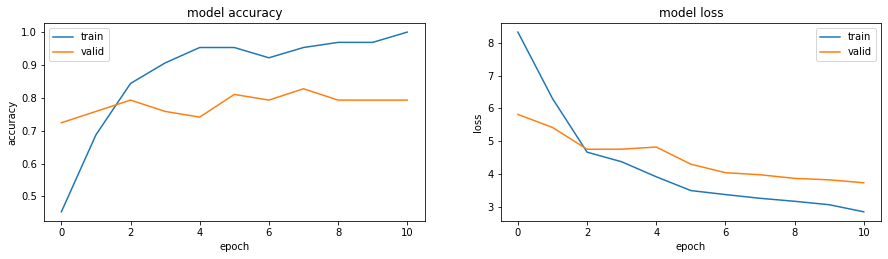

In [22]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

### Inception V3

In [23]:
# re-size all the images to this
IMAGE_SIZE = [299, 299]

train_path = 'Datasets/Train'
valid_path = 'Datasets/Test'

# useful for getting number of classes
folders = glob('Datasets/Train/*')
folders
initializer = K.initializers.he_normal()
model = K.applications.InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)


for layer in model.layers:
  layer.trainable = False


output = Flatten()(model.output)
layer_256 = K.layers.Dense(units=256,
                           activation='elu',
                           kernel_initializer=initializer,
                           kernel_regularizer=K.regularizers.l2())
output = layer_256(output)
dropout = K.layers.Dropout(0.5)
output = dropout(output)
softmax = K.layers.Dense(units=len(folders),
                         activation='softmax',
                         kernel_initializer=initializer,
                         kernel_regularizer=K.regularizers.l2())
output = softmax(output)
model = K.models.Model(inputs=model.input, outputs=output)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_96 (Conv2D)              (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_96[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [24]:
model.compile(
         optimizer=K.optimizers.Adam(learning_rate=1e-4),
         loss='categorical_crossentropy',
         metrics=['accuracy'])

### Call back functions to be used while training 

# reduce learning rate when val_accuracy has stopped improving
lr_reduce = K.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                          factor=0.6,
                                          patience=2,
                                          verbose=1,
                                          mode='max',
                                          min_lr=1e-7)
# stop training when val_accuracy has stopped improving
early_stop = K.callbacks.EarlyStopping(monitor='val_accuracy',
                                       patience=3,
                                       verbose=1,
                                       mode='max')
# callback to save the Keras model and (best) weights obtained on an epoch basis. here, the trained (compiled) model is saved in the current working directory as 'cifar10.h5'
checkpoint = K.callbacks.ModelCheckpoint('car_brand_Inceptionv3.h5',
                                         monitor='val_accuracy',
                                         verbose=1,
                                         save_weights_only=False,
                                         save_best_only=True,
                                         mode='max',
                                         save_freq='epoch')


train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory('Datasets/Train',
                                                 target_size = (299, 299),
                                                 batch_size = 16,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('Datasets/Test',
                                            target_size = (299, 299),
                                            batch_size = 16,
                                            class_mode = 'categorical')

print('Length of Training Set : ' , len(training_set))
print('Length of Test Set : ' , len(test_set))

train_steps_per_epoch = len(training_set) // 32
val_steps_per_epoch = len(test_set) // 32

print('Train Steps per epoch : ', train_steps_per_epoch)
print('Validation Steps per epoch : ' , val_steps_per_epoch)

# fit the model
history = model.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=50,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set),
  callbacks=[lr_reduce, early_stop, checkpoint])

Found 64 images belonging to 3 classes.
Found 58 images belonging to 3 classes.
Length of Training Set :  4
Length of Test Set :  4
Train Steps per epoch :  0
Validation Steps per epoch :  0


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
4/4 [==============================] - 7s 913ms/step - loss: 9.1686 - accuracy: 0.6229 - val_loss: 7.4866 - val_accuracy: 0.4828

Epoch 00001: val_accuracy improved from -inf to 0.48276, saving model to car_brand_Inceptionv3.h5
Epoch 2/50
4/4 [==============================] - 2s 418ms/step - loss: 6.4739 - accuracy: 0.6771 - val_loss: 6.6745 - val_accuracy: 0.6724

Epoch 00002: val_accuracy improved from 0.48276 to 0.67241, saving model to car_brand_Inceptionv3.h5
Epoch 3/50
4/4 [==============================] - 2s 413ms/step - loss: 6.0284 - accuracy: 0.8042 - val_loss: 6.0299 - val_accuracy: 0.7414

Epoch 00003: val_accuracy improved from 0.67241 to 0.74138, saving model to car_brand_Inceptionv3.h5
Epoch 4/50
4/4 [==============================] - 2s 414ms/step - loss: 5.6216 - accuracy: 0.7688 - val_loss: 5.8219 - val_accuracy: 0.7414

Epoch 00004: val_accuracy did not improve from 0.74138
Epoch 5/50
4/4 [==============================] - 2s 400ms/step - loss: 5.2409 - 

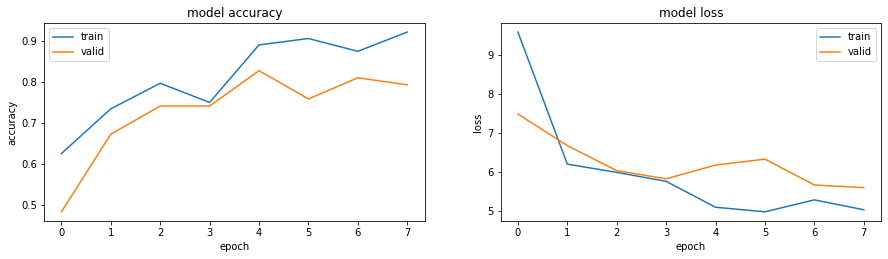

In [25]:
plt.figure(1, figsize = (15,8))
plt.subplot(221)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])
plt.show()

Testing it on Test Set completely


In [26]:
y_pred = model.predict(test_set)

In [27]:
y_pred

array([[1.65275167e-04, 9.99783933e-01, 5.07137556e-05],
       [2.16108398e-09, 9.99998093e-01, 1.94618019e-06],
       [7.48645165e-04, 7.45359302e-01, 2.53892034e-01],
       [3.68679842e-08, 9.99985456e-01, 1.44928299e-05],
       [5.18308261e-05, 3.03335703e-08, 9.99948144e-01],
       [2.07277574e-03, 9.97927070e-01, 8.31412592e-08],
       [9.63791755e-11, 9.99999881e-01, 1.03496014e-07],
       [1.87782501e-03, 2.91180581e-01, 7.06941605e-01],
       [5.28735435e-03, 9.47673500e-01, 4.70390804e-02],
       [1.97958425e-01, 1.22300491e-01, 6.79741085e-01],
       [4.38066672e-05, 1.83446726e-12, 9.99956250e-01],
       [8.93003094e-09, 9.99999881e-01, 8.12671885e-08],
       [6.67122230e-02, 2.38151415e-06, 9.33285415e-01],
       [9.97101605e-01, 1.84638776e-13, 2.89841183e-03],
       [7.76319276e-13, 1.00000000e+00, 8.52471219e-11],
       [9.99999404e-01, 8.73694174e-22, 6.18521256e-07],
       [2.01366711e-02, 1.39737299e-12, 9.79863346e-01],
       [4.16821495e-05, 1.66310

In [29]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 1, 2, 0, 1, 0, 2, 2, 2, 1, 2, 1,
       1, 1, 1, 2, 1, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2,
       0, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2])

### Loading a Saved Model

In [54]:
model = load_model('car_brand_resnet152v2.h5')

In [55]:
img=image.load_img('Datasets/Test/lamborghini/11.jpg',target_size=(224,224))

In [56]:
x = image.img_to_array(img)
x

array([[[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [196., 187., 172.],
        [217., 208., 193.],
        [243., 234., 219.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [245., 245., 237.],
        [243., 243., 235.],
        [242., 242., 234.]],

       [[252., 252., 252.],
        [252., 252., 252.],
        [252., 252., 252.],
        ...,
        [240., 249., 248.],
        [242., 251., 250.],
        [242., 251., 250.]],

       ...,

       [[189., 207., 229.],
        [190., 206., 229.],
        [190., 206., 229.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 206., 227.],
        ...,
        [171., 180., 187.],
        [171., 180., 187.],
        [171., 180., 187.]],

       [[185., 206., 227.],
        [185., 206., 227.],
        [185., 2

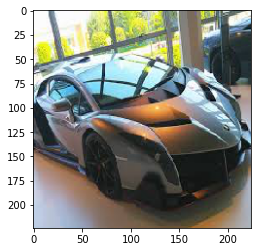

In [57]:
plt.imshow(x.astype('uint8'))
plt.show()

In [58]:
x.shape

(224, 224, 3)

Rescaling of Image i-e Normalization

In [59]:
x = x/255
x

array([[[0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        ...,
        [0.76862746, 0.73333335, 0.6745098 ],
        [0.8509804 , 0.8156863 , 0.75686276],
        [0.9529412 , 0.91764706, 0.85882354]],

       [[0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        ...,
        [0.9607843 , 0.9607843 , 0.92941177],
        [0.9529412 , 0.9529412 , 0.92156863],
        [0.9490196 , 0.9490196 , 0.91764706]],

       [[0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        [0.9882353 , 0.9882353 , 0.9882353 ],
        ...,
        [0.9411765 , 0.9764706 , 0.972549  ],
        [0.9490196 , 0.9843137 , 0.98039216],
        [0.9490196 , 0.9843137 , 0.98039216]],

       ...,

       [[0.7411765 , 0.8117647 , 0.8980392 ],
        [0.74509805, 0.80784315, 0.8980392 ],
        [0.74509805, 0

In [60]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
x = np.expand_dims(x,axis=0)
x.shape

(1, 224, 224, 3)

In [61]:
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [62]:
res = model.predict(img_data)
res

array([[0.03671238, 0.17718627, 0.7861013 ]], dtype=float32)

In [63]:
output_res = np.argmax(res,axis=1)
output_res

array([2])

#### Loading Model in Flask

In [12]:
import tensorflow_hub as hub
from tensorflow.keras.models import load_model
model = load_model('car_brand_vgg19.h5',custom_objects={'KerasLayer':hub.KerasLayer})